# Insurance Fraud Claims Detection

This notebook summarizes the steps I did for building the model and the information I need to put our model in production

**Premise: Setting the seed**

Because now we have to move the model in production for reproducibility it's important to **set the seed**

## Libraries and Environments

In [1]:
# Read the data
import pandas as pd
import numpy as np

# Data Science
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

# Model Deployment
import joblib
# from skl2onnx import convert_sklearn
# from skl2onnx.common.data_types import DoubleTensorType
# import onnxruntime as rt
# from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
# from onnxmltools.utils import save_model

#Utils
from collections import Counter
import os
import yaml
import ruamel.yaml
import sys

# Set notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.simplefilter(action='ignore')

In [2]:
raw = '../data/raw/insurance_claims.csv'
interim = '../data/interim/'
processed= '../data/processed/'
reports= '../reports/'
models= '../models/'
src= '../src/'

## Data Ingestion

In [3]:
metadata = {}
metadata['data_ingestion'] = {}
metadata['data_ingestion']['data_path'] = 'TOFILL'

### Load Data

In [4]:
data = pd.read_csv(raw)
print(data.shape)
data.head()

(1000, 40)


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


### Data Mapping

In [5]:
metadata['data_ingestion']['data_map'] = {}

target = 'fraud_reported'
variables = [col for col in data.columns if col != target]

metadata['data_ingestion']['data_map']['target'] = target
metadata['data_ingestion']['data_map']['variables'] = variables

## Preprocessing

In [6]:
metadata['preprocessing'] = {}

### Drop Variables and Replace missleading labels

In [7]:
drop = ['policy_number', 'policy_bind_date', 'policy_state', 'policy_csl', 
        'insured_zip', 'insured_occupation', 'incident_date', 
        'insured_education_level', 'insured_relationship', 'injury_claim', 'property_claim', 'vehicle_claim', 
        'incident_state', 'incident_city', 'incident_location', 'auto_model', 'auto_make', 'auto_year', '_c39']

metadata['preprocessing']['dropped_columns'] = drop

data.drop(drop, axis=1, inplace=True)

In [8]:
rename = {"capital-gains": "capital_gains", "capital-loss": "capital_loss"}

metadata['preprocessing']['renamed_columns'] = rename

data.rename(columns=rename, inplace=True)

In [9]:
predictors = [col for col in data.columns if col != target]
metadata['preprocessing']['predictors'] = predictors

### Drop anomalies 

In [10]:
data = data[data['umbrella_limit']>=0]

In [11]:
print('\n', data['umbrella_limit'].unique())


 [       0  5000000  6000000  4000000  3000000  8000000  7000000  9000000
 10000000  2000000]


### Impute Missing

In [12]:
missing_predictors = [col for col in data.select_dtypes(include='object').columns if any(data[col].str.contains('?', regex=False))]

metadata['preprocessing']['missing_predictors'] = missing_predictors

data[missing_predictors] = data[missing_predictors].replace('?', 'missing')

In [13]:
for var in missing_predictors:
    print('{} labels: {}'.format(var, data[var].unique()))
    print()

collision_type labels: ['Side Collision' 'missing' 'Rear Collision' 'Front Collision']

property_damage labels: ['YES' 'missing' 'NO']

police_report_available labels: ['YES' 'missing' 'NO']



### Train-Test splitting

In [14]:
metadata['preprocessing']['train_test_split_params']={}
metadata['preprocessing']['train_test_split_params']['test_size'] = 0.10
metadata['preprocessing']['train_test_split_params']['random_state'] = 1

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data[predictors], data[target],
                                                    test_size=0.10, 
                                                    random_state=1) # ALWAYS set random seed for reproducibility!
X_train.shape, X_test.shape

((899, 20), (100, 20))

## Feature engineering

In [16]:
metadata['features_engineering'] = {}

### Engineer Target

In [17]:
y_train.unique()

array(['N', 'Y'], dtype=object)

In [18]:
metadata['features_engineering']['target_encoding'] = {}

In [19]:
#Create the list of target labels
target_labels = sorted(set(y_train))
#Create encoding dictionary
target_labels_dic = {label: index for index, label in enumerate(target_labels, 0)}

In [20]:
metadata['features_engineering']['target_encoding'] = target_labels_dic

In [21]:
#Encode the data
y_train = y_train.map(target_labels_dic).astype('category')
y_test = y_test.map(target_labels_dic).astype('category')

In [22]:
print(y_train.unique())
print()
print(y_test.unique())

[0, 1]
Categories (2, int64): [0, 1]

[0, 1]
Categories (2, int64): [0, 1]


### Engineer Numerical Variables

I divided them in: 

- Discrete variables
- Continuous variables


In [23]:
# numerical
numerical_predictors = [col for col in predictors if X_train[col].dtypes != 'object']
discrete_predictors = [col for col in numerical_predictors if len(X_train[col].unique()) < 30]
continuous_predictors = [col for col in numerical_predictors if col not in discrete_predictors]

print(numerical_predictors)
print('\n', discrete_predictors)
print('\n', continuous_predictors)

metadata['features_engineering']['numerical_predictors'] = numerical_predictors
metadata['features_engineering']['discrete_predictors'] = discrete_predictors
metadata['features_engineering']['continuous_predictors'] = continuous_predictors

['months_as_customer', 'age', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'capital_gains', 'capital_loss', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'total_claim_amount']

 ['policy_deductable', 'umbrella_limit', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses']

 ['months_as_customer', 'age', 'policy_annual_premium', 'capital_gains', 'capital_loss', 'total_claim_amount']


#### Discrete Variables

In [24]:
X_train[discrete_predictors].head()

,policy_deductable,umbrella_limit,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses
336,500,4000000,14,3,2,1
13,1000,0,5,1,1,1
872,1000,0,23,3,0,0
156,2000,0,10,3,2,1
429,2000,0,2,1,2,3


#### policy_deductable

In [25]:
metadata['features_engineering']['binned_variables'] = []
metadata['features_engineering']['binned_variables'].append('policy_deductable')

In [26]:
bins = list(np.linspace(0,2000, 5, dtype = int))
bin_labels = ['0-500', '501-1000', '1001-1500', '1501-2000']
new_variable_name = "_".join(['policy_deductable', 'groups'])

In [27]:
metadata['features_engineering']['binning_meta'] = {}
binning_meta={}
binning_meta['var_name'] = new_variable_name
binning_meta['bins'] = [0, 500, 1000, 1500, 2000]
binning_meta['bins_labels'] = bin_labels
metadata['features_engineering']['binning_meta']['policy_deductable'] = binning_meta

In [28]:
X_train[new_variable_name] = pd.cut(X_train['policy_deductable'], bins = bins, labels = bin_labels, include_lowest = True)
X_test[new_variable_name] = pd.cut(X_test['policy_deductable'], bins = bins, labels = bin_labels, include_lowest = True)
X_train.drop('policy_deductable', axis=1, inplace=True)
X_test.drop('policy_deductable', axis=1, inplace=True)

In [29]:
print('\n', X_train[new_variable_name].unique())
print()
print('\n', X_test[new_variable_name].unique())


 [0-500, 501-1000, 1501-2000]
Categories (3, object): [0-500 < 501-1000 < 1501-2000]


 [501-1000, 0-500, 1501-2000]
Categories (3, object): [0-500 < 501-1000 < 1501-2000]


#### Continuous variables

In [30]:
X_train[continuous_predictors].head()

,months_as_customer,age,policy_annual_premium,capital_gains,capital_loss,total_claim_amount
336,176,39,1365.46,0,-56600,44280
13,121,34,936.61,52800,-32800,7280
872,290,45,1311.30,38500,0,52650
156,461,61,1402.75,0,0,72100
429,467,58,977.40,82200,0,55700


#### age

In [31]:
metadata['features_engineering']['binned_variables'].append('age')

In [32]:
bin_labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65']
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
new_variable_name = "_".join(['age', 'groups'])

In [33]:
# Encoding meta
binning_meta = {}
binning_meta['var_name'] = new_variable_name
binning_meta['bins'] = bins
binning_meta['bins_labels'] = bin_labels
metadata['features_engineering']['binning_meta']['age'] = binning_meta

In [34]:
X_train[new_variable_name] = pd.cut(X_train['age'], bins = bins, labels = bin_labels, include_lowest = True)
X_test[new_variable_name] = pd.cut(X_test['age'], bins = bins, labels = bin_labels, include_lowest = True)
X_train.drop('age', axis=1, inplace=True)
X_test.drop('age', axis=1, inplace=True)

In [35]:
print('\n', X_train[new_variable_name].unique())
print()
print('\n', X_test[new_variable_name].unique())


 [36-40, 31-35, 41-45, 61-65, 56-60, 26-30, 46-50, 51-55, 21-25, 15-20]
Categories (10, object): [15-20 < 21-25 < 26-30 < 31-35 ... 46-50 < 51-55 < 56-60 < 61-65]


 [21-25, 56-60, 36-40, 46-50, 31-35, 41-45, 26-30, 51-55, 61-65]
Categories (9, object): [21-25 < 26-30 < 31-35 < 36-40 ... 46-50 < 51-55 < 56-60 < 61-65]


#### policy_annual_premium

In [36]:
metadata['features_engineering']['binned_variables'].append('policy_annual_premium')

In [37]:
bins = list(np.linspace(0, 2500, 6, dtype = int))
bin_labels = ['very low', 'low', 'medium', 'high', 'very high']
new_variable_name = "_".join(['policy_annual_premium', 'groups'])

In [38]:
# Encoding meta
binning_meta = {}
binning_meta['var_name'] = new_variable_name
binning_meta['bins'] = [0, 500, 1000, 1500, 2000, 2500]
binning_meta['bins_labels'] = bin_labels
metadata['features_engineering']['binning_meta']['policy_annual_premium'] = binning_meta

In [39]:
X_train[new_variable_name] = pd.cut(X_train['policy_annual_premium'], bins = bins, labels = bin_labels, include_lowest = True)
X_test[new_variable_name] = pd.cut(X_test['policy_annual_premium'], bins = bins, labels = bin_labels, include_lowest = True)
X_train.drop('policy_annual_premium', axis=1, inplace=True)
X_test.drop('policy_annual_premium', axis=1, inplace=True)

In [40]:
print('\n', X_train[new_variable_name].unique())
print()
print('\n', X_test[new_variable_name].unique())


 [medium, low, high, very low, very high]
Categories (5, object): [very low < low < medium < high < very high]


 [medium, high, low]
Categories (3, object): [low < medium < high]


#### month_as_customer

In [41]:
metadata['features_engineering']['binned_variables'].append('months_as_customer')

In [42]:
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bin_labels = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400','401-450','451-500']
new_variable_name = "_".join(['months_as_customer', 'groups'])

In [43]:
# Encoding meta
binning_meta = {}
binning_meta['var_name'] = new_variable_name
binning_meta['bins'] = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
binning_meta['bins_labels'] = bin_labels
metadata['features_engineering']['binning_meta']['months_as_customer'] = binning_meta

In [44]:
X_train[new_variable_name] = pd.cut(X_train['months_as_customer'], bins = bins, labels = bin_labels, include_lowest = True)
X_test[new_variable_name] = pd.cut(X_test['months_as_customer'], bins = bins, labels = bin_labels, include_lowest = True)
X_train.drop('months_as_customer', axis=1, inplace=True)
X_test.drop('months_as_customer', axis=1, inplace=True)

In [45]:
print('\n', X_train[new_variable_name].unique())
print()
print('\n', X_test[new_variable_name].unique())


 [151-200, 101-150, 251-300, 451-500, 0-50, 201-250, 51-100, 301-350, 401-450, 351-400]
Categories (10, object): [0-50 < 51-100 < 101-150 < 151-200 ... 301-350 < 351-400 < 401-450 < 451-500]


 [51-100, 451-500, 0-50, 301-350, 151-200, 101-150, 201-250, 251-300, 351-400, 401-450]
Categories (10, object): [0-50 < 51-100 < 101-150 < 151-200 ... 301-350 < 351-400 < 401-450 < 451-500]


### Engineer Categorical variables

In [46]:
# non numerical
categorical_predictors = [col for col in X_train.columns if X_train[col].dtypes != 'int' and col != target]
ordinal_predictors = ['incident_severity', 'policy_annual_premium_groups', 'policy_deductable_groups']
nominal_predictors = [col for col in categorical_predictors if col not in ordinal_predictors]

print(categorical_predictors)
print('\n', ordinal_predictors)
print('\n', nominal_predictors)

metadata['features_engineering']['categorical_predictors'] = categorical_predictors
metadata['features_engineering']['ordinal_predictors'] = ordinal_predictors
metadata['features_engineering']['nominal_predictors'] = nominal_predictors

['insured_sex', 'insured_hobbies', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'property_damage', 'police_report_available', 'policy_deductable_groups', 'age_groups', 'policy_annual_premium_groups', 'months_as_customer_groups']

 ['incident_severity', 'policy_annual_premium_groups', 'policy_deductable_groups']

 ['insured_sex', 'insured_hobbies', 'incident_type', 'collision_type', 'authorities_contacted', 'property_damage', 'police_report_available', 'age_groups', 'months_as_customer_groups']


#### Nominal

#### insured_hobbies

In [47]:
# Encoded variables
metadata['features_engineering']['encode_variables'] = []
metadata['features_engineering']['encode_variables'].append('insured_hobbies')

In [48]:
replace_labels = [label for label in X_train['insured_hobbies'].unique() if label not in ['chess', 'cross-fit']]
bins_label_var = {l: 'others' if l in replace_labels else l for l in X_train['insured_hobbies'].unique()}

In [49]:
# Encoding meta
metadata['features_engineering']['encoding_meta'] = {}
metadata['features_engineering']['encoding_meta']['insured_hobbies'] = bins_label_var

In [50]:
X_train['insured_hobbies'] = X_train['insured_hobbies'].map(bins_label_var)
X_test['insured_hobbies'] = X_test['insured_hobbies'].map(bins_label_var)

#### Create Dummies

In [51]:
metadata['features_engineering']['dummies_meta'] = {}
for var in nominal_predictors:
    cat_names = list(X_train[var].unique())
    metadata['features_engineering']['dummies_meta'][var] = cat_names

In [52]:
# Dummies
X_train = pd.get_dummies(X_train, columns=nominal_predictors)
X_test = pd.get_dummies(X_test, columns=nominal_predictors)

#### Ordinal

In [53]:
ord_var_labels = {col: [str(l) for l in X_train[col].unique()] for col in ordinal_predictors}

#### incident_severity

In [54]:
# Encoded variables
metadata['features_engineering']['encode_variables'].append('incident_severity')

In [55]:
categories = pd.Categorical(X_train[ordinal_predictors]['incident_severity'],
                                  categories=['Trivial Damage',
                                              'Minor Damage',
                                              'Major Damage',
                                              'Total Loss'],
                                  ordered=True)
labels, unique = pd.factorize(categories, sort=True)
labels_code_dic = {label: index.tolist() for index, label in zip(list(set(labels)), unique)}    

In [56]:
# Encoding meta
metadata['features_engineering']['encoding_meta']['incident_severity'] = labels_code_dic

In [57]:
X_train['incident_severity'] = labels

In [58]:
print('incident_severity', ':', X_train['incident_severity'].unique())

incident_severity : [1 2 3 0]


In [59]:
categories = pd.Categorical(X_test[ordinal_predictors]['incident_severity'],
                                  categories=['Trivial Damage',
                                              'Minor Damage',
                                              'Major Damage',
                                              'Total Loss'],
                                  ordered=True)
labels, unique = pd.factorize(categories, sort=True)

In [60]:
X_test['incident_severity'] = labels

In [61]:
print('incident_severity', ':', X_test['incident_severity'].unique())

incident_severity : [3 1 2 0]


#### policy_annual_premium_groups

In [62]:
# Encoded variables
metadata['features_engineering']['encode_variables'].append('policy_annual_premium_groups')

In [63]:
categories = pd.Categorical(X_train[ordinal_predictors]['policy_annual_premium_groups'],
                                          categories=['very low',
                                                  'low',
                                                  'medium',
                                                  'high',
                                                  'very high'],
                                          ordered=True)

labels, unique = pd.factorize(categories, sort=True)
labels_code_dic = {label: index.tolist() for index, label in zip(list(set(labels)), unique)}    

In [64]:
# Encoding meta
metadata['features_engineering']['encoding_meta']['policy_annual_premium_groups'] = labels_code_dic

In [65]:
X_train['policy_annual_premium_groups'] = labels

In [66]:
print('policy_annual_premium_groups', ':', X_train['policy_annual_premium_groups'].unique())

policy_annual_premium_groups : [2 1 3 0 4]


In [67]:
categories = pd.Categorical(X_test[ordinal_predictors]['policy_annual_premium_groups'],
                                          categories=['very low',
                                                  'low',
                                                  'medium',
                                                  'high',
                                                  'very high'],
                                          ordered=True)

labels, unique = pd.factorize(categories, sort=True)

In [68]:
X_test['policy_annual_premium_groups'] = labels

In [69]:
print('policy_annual_premium_groups', ':', X_test['policy_annual_premium_groups'].unique())

policy_annual_premium_groups : [1 2 0]


#### policy_deductable_groups

In [70]:
# Encoded variables
metadata['features_engineering']['encode_variables'].append('policy_deductable_groups')

In [71]:
categories = pd.Categorical(X_train[ordinal_predictors]['policy_deductable_groups'],
                               categories=['0-500', '501-1000', '1001-1500', '1501-2000'],
                               ordered=True)

labels, unique = pd.factorize(categories, sort=True)
labels_code_dic = {label: index.tolist() for index, label in zip(list(set(labels)), unique)}    

In [72]:
# Encoding meta
metadata['features_engineering']['encoding_meta']['policy_deductable_groups'] = labels_code_dic

In [73]:
X_train['policy_deductable_groups'] = labels

In [74]:
print('policy_deductable_groups', ':', X_train['policy_deductable_groups'].unique())

policy_deductable_groups : [0 1 2]


In [75]:
categories = pd.Categorical(X_test[ordinal_predictors]['policy_deductable_groups'],
                               categories=['0-500', '501-1000', '1001-1500', '1501-2000'],
                               ordered=True)

labels, unique = pd.factorize(categories, sort=True)

In [76]:
X_test['policy_deductable_groups'] = labels

In [77]:
print('policy_deductable_groups', ':', X_test['policy_deductable_groups'].unique())

policy_deductable_groups : [1 0 2]


### Feature Scaling

In [78]:
features = [col for col in X_train.columns if col != 'fraud_reported']
metadata['features_engineering']['features'] = features

In [79]:
# create scaler
scaler = MinMaxScaler()

#  fit the scaler to the train set
scaler.fit(X_train[features]) 

# transform the train and test set
X_train[features] = scaler.transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

In [80]:
metadata['features_engineering']['scaler_path'] = 'TOFILL'

### Selected features

In [81]:
# load selected features
features_selected = pd.read_csv(processed + 'selected_features.csv', names=['features'])
features_selected = list(features_selected['features'])

print('Number of features: ', len(features_selected))
print('\n', sorted(features_selected))

metadata['features_engineering']['features_selected'] = sorted(features_selected)

Number of features:  13

 ['bodily_injuries', 'capital_gains', 'capital_loss', 'incident_hour_of_the_day', 'incident_severity', 'insured_hobbies_chess', 'insured_hobbies_cross-fit', 'insured_hobbies_others', 'policy_annual_premium_groups', 'policy_deductable_groups', 'total_claim_amount', 'umbrella_limit', 'witnesses']


In [82]:
X_train = X_train[features_selected]
X_test = X_test[features_selected]

In [83]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(899, 13) (899,)
(100, 13) (100,)


### Balancing

In [84]:
smote = SMOTE(random_state=9)
metadata['features_engineering']['random_sample_smote'] = 9

In [85]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [86]:
print(y_train.value_counts()/len(y_train), '\n')

1    0.5
0    0.5
Name: fraud_reported, dtype: float64 



## Model Training: Random Forest

In [87]:
metadata['model_training']={}
metadata['model_training']['model_path'] = 'TOFILL'
metadata['model_training']['RandomForestClassifier'] = {}

In [88]:
metadata['model_training']['RandomForestClassifier']['max_depth'] = 25
metadata['model_training']['RandomForestClassifier']['min_samples_split'] = 5
metadata['model_training']['RandomForestClassifier']['n_estimators'] = 300
metadata['model_training']['RandomForestClassifier']['random_state'] = 8

********************
**Model Assessment**
********************
score: 0.85

Classification report
              precision    recall  f1-score   support

           0       0.96      0.85      0.90        79
           1       0.60      0.86      0.71        21

    accuracy                           0.85       100
   macro avg       0.78      0.85      0.80       100
weighted avg       0.88      0.85      0.86       100


Confusion Matrix


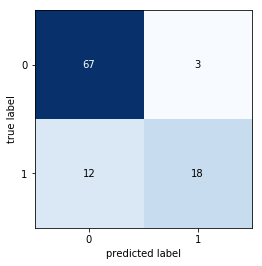

In [89]:
rfor = RandomForestClassifier(max_depth=25, min_samples_split=5, n_estimators=300,
                       random_state=8)

rfor.fit(X_train, y_train)
predictions = rfor.predict(X_test)

print("*"*20)
print("Model Assessment".center(20, '*'))
print("*"*20)

print('score: {}'.format(round(rfor.score(X_test, y_test), 3)))
print()

print('Classification report')
print(classification_report(y_test, predictions))

print()

print('Confusion Matrix')
conf_matrix = confusion_matrix(predictions, y_test)
plot_confusion_matrix(conf_matrix);

## Final predictions

In [90]:
print("predict", rfor.predict(X_train[:1]))
# print("predict_proba", rfor.predict_proba(X[:1]))

predict [0]


## Model Persistence: Pickle

In [91]:
joblib.dump(rfor, models + 'rf_champion.joblib')

['../models/rf_champion.joblib']

In [92]:
rfor_test = joblib.load(models + 'rf_champion.joblib') 

In [93]:
print('predict', rfor_test.predict(X_train[:1]))

predict [0]


<!-- ### Convert into ONNX format //-->

<!--
# Tell ONNX features of the model
initial_type = [('features_input', DoubleTensorType([1, X_train.shape[1]]))]

# Convert the trained model to an ONNX format.
onnx = convert_sklearn(rfor, name='rf_champion', initial_types=initial_type)

# Save your model locally
with open(models + "rf_champion.onnx", "wb") as f:
    f.write(onnx.SerializeToString())
//-->

<!-- ### Draw the Model //-->

<!--
pydot_graph = GetPydotGraph(
    onnx.graph, name=onnx.graph.name, rankdir="TB",
    node_producer=GetOpNodeProducer(
        "docstring", color="yellow",
        fillcolor="yellow", style="filled"))
pydot_graph.write_dot(reports + "rfor_onnx_schema.dot")

//-->

<!--

os.system('dot -O -Gdpi=300 -Tpng ../reports/rfor_onnx_schema.dot')

image = plt.imread(reports + "rfor_onnx_schema.dot.png")
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(image)
ax.axis('off')

//-->

<!--
# setup runtime and load model
sess = rt.InferenceSession(models + "rf_champion.onnx")

# get model metadata for scoring
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name

score_me = np.array(X_train[:1], dtype=np.float64)
# predictions
predictions_onnx = sess.run([label_name], {input_name: score_me})
//-->

<!--
print("predict", predictions_onnx[0])
# print("predict_proba", predictions_onnx[][:1])
//-->

That is all for this notebook.

**Move on productionalizing this model for model deployment**.

In [94]:
metadata

{'data_ingestion': {'data_path': 'TOFILL',
  'data_map': {'target': 'fraud_reported',
   'variables': ['months_as_customer',
    'age',
    'policy_number',
    'policy_bind_date',
    'policy_state',
    'policy_csl',
    'policy_deductable',
    'policy_annual_premium',
    'umbrella_limit',
    'insured_zip',
    'insured_sex',
    'insured_education_level',
    'insured_occupation',
    'insured_hobbies',
    'insured_relationship',
    'capital-gains',
    'capital-loss',
    'incident_date',
    'incident_type',
    'collision_type',
    'incident_severity',
    'authorities_contacted',
    'incident_state',
    'incident_city',
    'incident_location',
    'incident_hour_of_the_day',
    'number_of_vehicles_involved',
    'property_damage',
    'bodily_injuries',
    'witnesses',
    'police_report_available',
    'total_claim_amount',
    'injury_claim',
    'property_claim',
    'vehicle_claim',
    'auto_make',
    'auto_model',
    'auto_year',
    '_c39']}},
 'preprocessing

In [95]:
with open(src + 'config.yaml', 'w') as file:
    config_file = ruamel.yaml.round_trip_dump(metadata, file, indent=4, default_flow_style=False)
file.close()